# Проработка вариантов решения (и EDA новых данных)

In [271]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
from PIL import Image
import pandas as pd
from sklearn.metrics import silhouette_score
from collections import Counter
from sklearn.cluster import DBSCAN
from spellchecker import SpellChecker
from difflib import SequenceMatcher
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import imagehash
import cv2
from io import BytesIO
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import easyocr
from nltk.tokenize import word_tokenize
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords
import pytesseract

# 1. Проанализировать имеющиеся решения. Обозначить основные плюсы и минусы каждого из потенциальных решений. Выбрать подходящее решение (алгоритм или набор алгоритмов) для данной задачи и обосновать его

__Имеющиеся подходы:__

Computer Vision: можно использовать методы компьютерного зрения для извлечения признаков из изображений и дальнейшего анализа этих признаков для определения наличия рекламы.

Обработка текста: можно извлекать текст из изображений и анализировать его на предмет наличия ключевых слов, указывающих на рекламу.

__плюсы и минусы:__

Computer Vision:

Плюсы: способность извлечь сложные признаки из изображений.

Минусы: сложность реализации, возможны потери информации при извлечении признаков.

Обработка текста:

Плюсы: относительно простой подход, позволяет быстро определить наличие ключевых слов в изображениях.

Минусы: не учитывает контекст, может давать ложноположительные результаты.

__Вывод:__

Исходя из особенностей задачи (определение наличия рекламы) и вышеперечисленных плюсов и минусов подходов, наиболее подходящим решением кажется использование комбинации методов Computer Vision и обработки текста. Computer Vision поможет найти выбросы в данных, а также использовать предобученную модель для классификации, а обработка текста позволит учитывать содержание текста на изображениях. Такой подход позволит достичь высокой точности и учесть разнообразие способов размещения рекламы на изображениях.


# 4. В этом разделе:
# Проведем первичный разведочный анализ на новых данных (EDA)
# Сформируем обучающую выборку
# Спроектируем схему валидации с учетом специфики задачи

Сначала приведу код, который испоьзуется для разделения выборки на тренировочную и тестовую. Для поиска схожих изображений используется перцептивное хеширование, а именно phash. Вычисленный хеш изображения сравнивается с хешем остальных изображений, и если разница меньше или равна 5, что говорит о большой схожести двух изображений, тогда в датасете останется только одно из схожих изображений.

Так как есть дисбаланс классов - допустимых в 4-5 раз больше чем недопустимых, то после разделение выборки на train и test проведем upsampling меньшей выборки - недопустимых изображений. Upsampling проводится исключительно на тренировочной выборке. После увеличения выборки, чтобы не было схожих изображений сделаем аугментацию, чтобы модель могла обучаться каждый раз на новых объектах и имела более высокую обобщающую способность

В части с EDA особо ничего не менял. Добавил повороты изображений на 90 и -90 градусов для обнаружения вертикальных текстов. Также так как объем выборки увеличился в несколько раз, пришлось переписать неоптимальный код по памяти, то есть обычные функции переписал на генераторы, записи в списки изменил на записи в текстовый файл

In [256]:
def hamming_distance(img1, img2):
    h1 = imagehash.average_hash(img1)
    h2 = imagehash.average_hash(img2)
    return h2-h1


def open_img(img, acc):
        global path
        if acc:
            im = Image.open(f"{path}\\0\\{img}")
        else:
            im = Image.open(f"{path}\\1\\{img}")
        return im
    
def unique_image(mas, acc):
    hashs = []
    for i in tqdm(range(len(mas))):
        img = open_img(mas[i], acc)
        hashs.append(imagehash.phash(img))

    imgs = []
    flag = False
    for i in tqdm(range(len(hashs))):
        for j in range(i+1, len(hashs)):
            if hashs[i] - hashs[j] <= 5:
                flag = True
                break
        if not flag:
            imgs.append(mas[i])
        flag = False
    return imgs


new_mas1 = unique_image(mas1, False)
new_mas0 = unique_image(mas0, True)
print(f"Число допустимых изображений = {len(new_mas0)} (изначально было 15000)\nЧисло недопустимых изображений {len(new_mas1)} (изначально было 4808)")

Число допустимых изображений = 14996 (изначально было 15000)
Число недопустимых изображений 3643 (изначально было 4808)


In [285]:
augmentetion = transforms.Compose([  
    transforms.RandomRotation(degrees=20),
    transforms.ColorJitter(brightness=0.5, contrast=0.5),
])

y0, y1 = [0 for i in range(len(new_mas0))], [1 for i in range(len(new_mas1))]
train0, test0, y_train, y_test = train_test_split(new_mas0, y0, test_size=0.33, random_state=42)
train1, test1, y_train, y_test = train_test_split(new_mas1, y1, test_size=0.33, random_state=42)

t = len(train0) // len(train1)
print(f"В тренировочной выборке кол-во допустимых изображений превышает кол-во недопустимых в {t} раз")

В тренировочной выборке кол-во допустимых изображений превышает кол-во недопустимых в 4 раз


In [ ]:
for i in range(t-1):
    for ind, img in enumerate(train1):
        img = Image.open(f"{path}\\1\\{img}")
        augmentetion(img).save(f"{path}\\new_train_1\\img_{ind}.jpg")

---

теперь EDA, большинство кода это повтор первой части

Проделаем следующие действия:

* Посмотреть распределение данных: какая доля допустисых и недопустимых изображений содержит текст
* Кластеризация и визуализация изображений с метками 0 и 1 для обнаружения изображений, отнесенных не к тому классу
* Найдем наиболее часто встречающиеся слова в недопустимых избражениях и с помощью них постараемся найти изображения, отнесенные не к тому классу. Есть нюанс - изображение с меткой 1 может быть ошибочно отнесено к допустимым изображениям, так как есть изображения на которых вместо слов изображены картинки (например, деньги) и рукописный текст, который сложно распознать даже человеку))

Загрузим изображения из тренировочной выборки

In [47]:
path = "C:\\Users\\Vitaliy\\OneDrive\\Рабочий стол\\WBTECH\\new_data"
mas0 = os.listdir(f"{path}\\0")
mas1 = os.listdir(f"{path}\\1")

In [48]:
reader = easyocr.Reader(["ru", "en"], verbose=False)
pytesseract.pytesseract.tesseract_cmd = r'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'

def get_name_pic(mas, accept):
    for pic in mas:
        if accept == True:
            im = Image.open(f"{path}\\0\\{pic}")
        else:
            im = Image.open(f"{path}\\1\\{pic}")
        yield im

def is_text(result):
    ans = []
    for elem in result:
        for el in elem:
            if type(el) == str:
                ans.append(el)
    return ans != [], ans

def text2tesseract(img):
    text = pytesseract.image_to_string(img, lang='rus')
    return text

In [177]:
def hamming_distance(img1, img2):
    h1 = imagehash.average_hash(img1)
    h2 = imagehash.average_hash(img2)
    return h2-h1


def open_img(img, acc):
        global path
        if acc:
            im = Image.open(f"{path}\\0\\{img}")
        else:
            im = Image.open(f"{path}\\1\\{img}")
        return im
    
def unique_image(mas, acc):
    hashs = []
    for i in tqdm(range(len(mas))):
        img = open_img(mas[i], acc)
        hashs.append(imagehash.phash(img))

    imgs = []
    flag = False
    for i in tqdm(range(len(hashs))):
        for j in range(i+1, len(hashs)):
            if hashs[i] - hashs[j] <= 5:
                flag = True
                break
        if not flag:
            imgs.append(mas[i])
        flag = False
    return imgs

In [178]:
new_mas1 = unique_image(mas1, False)

100%|██████████| 4808/4808 [00:24<00:00, 195.63it/s] 


In [179]:
new_mas0 = unique_image(mas0, True)

100%|██████████| 15000/15000 [06:12<00:00, 40.27it/s]  


In [157]:
print(f"Число допустимых изображений = {len(new_mas0)} (изначально было 15000)\nЧисло недопустимых изображений {len(new_mas1)} (изначально было 4808)")

Число допустимых изображений = 14996 (изначально было 15000)
Число недопустимых изображений 3643 (изначально было 4808)


In [235]:
cnt0 = 0
cnt1 = 0
f0 = open("accept.txt", mode='w+', encoding='utf-8')
f1 = open("NOT_accept.txt", mode='w+', encoding='utf-8')

for img in get_name_pic(new_mas0, True):
    txt = is_text(reader.readtext(img))
    if txt[0]:
        cnt0 += 1
    for elem in txt[1]:
        f0.write(f"{elem} ")
    f0.write('\n')
f0.close()

for img in get_name_pic(new_mas1, False):
    txt = is_text(reader.readtext(img))
    if txt[0]:
        cnt1 += 1
    for elem in txt[1]:
        f1.write(f"{elem} ")
    f1.write('\n')
f1.close()

print(f"Доля допустимых изображений с текстом = {cnt0 / len(new_mas0)}\nДоля НЕдопустимых изображений с текстом = {cnt1 / len(new_mas1)}")  

Доля допустимых изображений с текстом = 0.4963323552947453
Доля НЕдопустимых изображений с текстом = 0.9906670326653857


In [227]:
df = pd.DataFrame({
    'path' : new_mas0 + new_mas1,
    'label' : ['допустимое' for i in range(len(new_mas0))] + ['НЕдопустимое' for i in range(len(new_mas1))],
    'is_text' : ['нет текста' for i in range(len(new_mas0) - cnt0)] + ['есть текст' for i in range(cnt0)] + ['нет текста' for i in range(len(new_mas1) - cnt1)] + ['есть текст' for i in range(cnt1)]
})

Text(0.5, 1.0, 'Доля допустимых и недопустимых изображений с текстом')

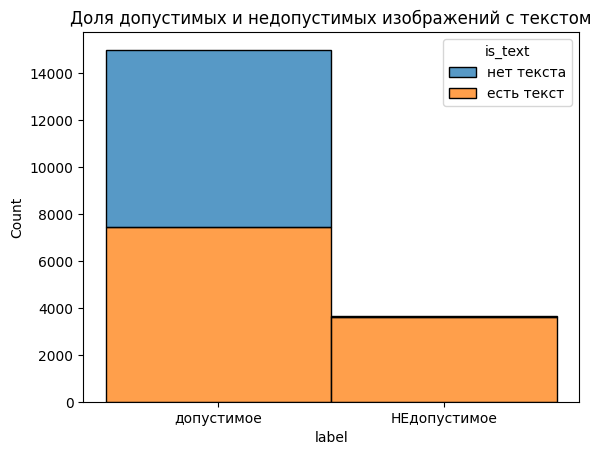

In [228]:
sns.histplot(data=df, x=df.label, hue=df.is_text, multiple="stack").set_title("Доля допустимых и недопустимых изображений с текстом")

Все недопустимые изображения содержат текст, однако, половина допустимых изображений также содержит текст

Кластеризуем изображения и провизуализируем их. Кластеризацию будем проводить следующим образом: пргоним каждое изображение через предобученную resnet, но перед этим удалим из нее слой полносвязной НС, далее получим вектора меньшей размерности, затем кластеризуем их при помощи Агломеративной кластеризации, и проверим качество при помощи метрики Силуэт. Для визуализации воспользуемся TSNE для понижения размерности до 2

Сначала выявим средний размер изображений и приведем все изображения к данному размеру

In [194]:
x = []
y = []
for i in tqdm(range(len(new_mas0))):
    img = Image.open(f"{path}\\0\\{new_mas0[i]}")
    x.append(img.size[0])
    y.append(img.size[1])
for i in tqdm(range(len(new_mas1))):
    img = Image.open(f"{path}\\1\\{new_mas1[i]}")
    x.append(img.size[0])
    y.append(img.size[1])

x_size, y_size = int(np.median(x)), int(np.median(y))
print(x_size, y_size)

100%|██████████| 3643/3643 [00:03<00:00, 1198.26it/s]

750 1000


In [195]:
transform = transforms.Compose([
    transforms.Resize((x_size, y_size)),
    transforms.ToTensor()
])

Создадим dataloader, чтобы изображения можно было скормить модели resnet

In [201]:
class Dataset:
    def __init__(self, pic0 : list, pic1 : list, path : str, transform):
        self.pic0 = pic0
        self.pic1 = pic1
        self.path = path
        self.transform = transform

    def __getitem__(self, ind):
        label = -1
        if ind >= len(self.pic0):
            ind -= len(self.pic0)
            img = Image.open(f"{path}\\1\\{self.pic1[ind]}")
            label = 1
        else:
            img = Image.open(f"{path}\\0\\{self.pic0[ind]}")
            label = 0

        im = self.transform(img)
        dt = {
            'image' : im,
            'label' : label
        }
        return dt
    
    def __len__(self):
        return len(self.pic0) + len(self.pic1)

In [213]:
data = Dataset(new_mas0, new_mas1, path, transform)
dataloader = DataLoader(data, batch_size=32, shuffle=False)

In [198]:
model = torchvision.models.resnet152(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])

c:\Users\Vitaliy\AppData\Local\Programs\Python\Python37\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
c:\Users\Vitaliy\AppData\Local\Programs\Python\Python37\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [223]:
features = []
labels = []
model.eval()

with torch.no_grad():
    for batch in tqdm(dataloader): 
        feats = model(batch['image'])
        features.append(feats.view(feats.size(0), -1))
        labels.append(batch['label'])

100%|██████████| 583/583 [15:35:24<00:00, 96.27s/it]    


In [229]:
features_cat = torch.cat(features)
labels_cat = torch.cat(labels)

Метрика ближе к 0, чем к 1, что говорит о перекрывающихся кластерах

In [230]:
tsne = TSNE(n_components=2, init='random', perplexity=50).fit_transform(features_cat)

c:\Users\Vitaliy\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [231]:
clusters = [i for i in range(2, 5)]
score = []

for k in clusters:
    clustering = AgglomerativeClustering(n_clusters=k).fit(features_cat)
    print(f"Число кластеров - {k}, метрика = {silhouette_score(features_cat, clustering.labels_)}")

Число кластеров - 2, метрика = 0.06754665821790695
Число кластеров - 3, метрика = 0.03891979530453682
Число кластеров - 4, метрика = 0.02025536820292473


Провизуализируем, понизив размерность

In [ ]:
clustering = AgglomerativeClustering(n_clusters=2).fit(features_cat)
plt.scatter(x=tsne[:, 0], y=tsne[:, 1], c=clustering.labels_, cmap='viridis', alpha=0.5)
plt.show()

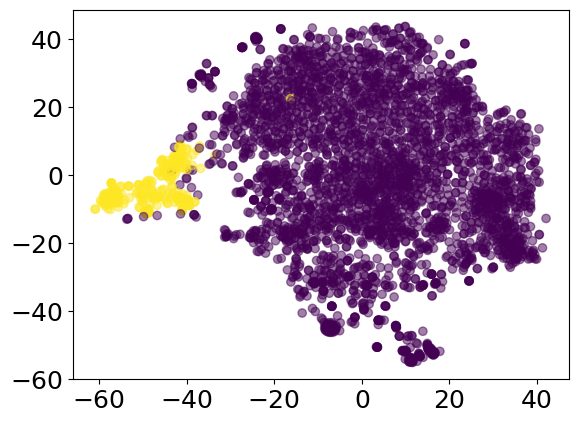

In [942]:
clustering = AgglomerativeClustering(n_clusters=2).fit(features_cat)
plt.scatter(x=tsne[:, 0], y=tsne[:, 1], c=clustering.labels_, cmap='viridis', alpha=0.5)
plt.show()

In [232]:
zero = features_cat[clustering.labels_ == 0]
one = features_cat[clustering.labels_ == 1]

In [233]:
dbscan = DBSCAN(eps=9, min_samples=3)

dbs = dbscan.fit_predict(zero)
cluster_labels = dbscan.labels_
outliers_0 = zero[cluster_labels == -1]

dbs = dbscan.fit_predict(one)
cluster_labels = dbscan.labels_
outliers_1 = one[cluster_labels == -1]

In [234]:
print(len(outliers_0), len(zero))
print(len(outliers_1), len(one))

123 8193
10 3509


In [1000]:
def find_vector(matrix, target_vector):
    for ind, vector in enumerate(matrix):
        if np.array_equal(vector, target_vector):
            return ind

In [1008]:
out_1 = find_vector(features_cat, outliers_1[0])
out_0 = find_vector(features_cat, outliers_0[0])
print(out_0, out_1)

50 2112


К сожалению, данный подход не помог обнаружить неверные метки изображений, поробуем решать данную задачу как задачу NLP

Определим слова, которые могут быть написаны в недопустимых изображениях

In [979]:
stop_words = {'@', 'руб', 'рублей', 'tg', 'тг', 'telegram', 'телега', 'график', 'деньги', 'отзывы', 'отзыв', 'платят', 'платить', 'пишите', 'писать', 'пиши', 'доход', 'зарплата', 'заработок' 'требуется', 'за'}

Теперь найдем все слова, которые встречаются в недопустимых изображениях и подсчитаем их количество

In [315]:
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

spell_checker = SpellChecker(language='ru')
bag_of_words = Counter()
morph = MorphAnalyzer()

In [316]:
flag = False
f1 = open("NOT_accept.txt", mode='r', encoding='utf-8')
text1 = f1.readlines()
f1.close()

f0 = open("NOT_accept.txt", mode='r', encoding='utf-8')
text0 = f0.readlines()
f0.close()

for text in tqdm(text1):
    new_text = []
    for elem in text:
        elem = word_tokenize(elem)
        for el in elem:
            new_text.append(el.translate(str.maketrans('', '', '!"#$%&\'()*+@,-./:;<=>?[\\]^_`{|}~')))

    for elem in new_text:
        for stop in stop_words:
            if stop in elem:
                bag_of_words[stop] += 1
                flag = True
                break
            elif similar(stop, elem) >= 0.7:
                bag_of_words[stop] += 1
                flag = True
                break

        if not flag: 
            correct = spell_checker.correction(elem) 
            if correct is None:
                correct = elem
            w = morph.parse(correct)[0].normal_form
            bag_of_words[w] += 1
                
        flag = False

100%|██████████| 700/700 [05:26<00:00,  2.14it/s]


создадим список стоп-слов из nltk, чтобы выкинуть некоторые слова из наиболее часто встречающихся слов среди недопустимых изображений

In [338]:
stops = set(stopwords.words('russian'))

найдем наиболее часто встречающиеся слова в недопустимых изображениях и выкинем из них стоп-слова и числовые строки

In [643]:
keys = []
for key, val in bag_of_words.items():
    if val > 60 and (not key.lower() in stops) and (not key.isnumeric()) and key != '' and len(key) and morph.parse(key)[0].score >= 0.5 and len(key) > 3:
        keys.append(key.lower())

In [644]:
keys

['нужный',
 'работа',
 'подробный',
 'писать',
 'деньги',
 'опыт',
 'отзыв',
 'телеграмма',
 'нужно',
 'искать',
 'рублей',
 'отзывы',
 'канал',
 'ребята',
 'телеграш',
 'деньга',
 'реальный',
 'платят']

Теперь при помощи поиска наиболее часто встречающихся слов и номеров телефонов в тексте изображений будем обнаруживать выбросы в данных.
Также дополнительно прогоним выходные изображения (которые мы будем считать выбросами) через еще одну ocr - pytesseract, так как она лучше работает с прописными буквами

Сначала найдем выбросы в недопустимых изображениях

In [1081]:
pytesseract.pytesseract.tesseract_cmd = r'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'

def text2tesseract(ind, accept):
    if accept:
        img = Image.open(f'{path}\\train\\0\\{mas0[ind]}')
    else:
        img = Image.open(f'{path}\\train\\1\\{mas1[ind]}')

    text = pytesseract.image_to_string(img, lang='rus')
    return text

def vertical(img):
    b = BytesIO()
    img2_1 = img.rotate(-90)
    img2_1.save(b,format="jpeg")
    image1 = Image.open(b)
    b = BytesIO()
    img2_2 = img.rotate(90)
    img2_2.save(b,format="jpeg")
    image2 = Image.open(b)
    text1 = is_text(easyocr(image1))
    text2 = is_text(easyocr(image2))
    return text1, text2

In [1138]:
flag = False
err0 = []

def find_noice(err, flag, text_n, accept):
    for ind, text in enumerate(text_n):
        #print(text)
        new_text = []
        for elem in text:
            elem1 = elem.split()
            for el in elem1:
                if el[0] == '@' and len(el) > 2:
                    new_text.append('@')
            elem = word_tokenize(elem)
            for el in elem:
                new_text.append(el.translate(str.maketrans('', '', '!"#$%&\'()@*+,-./:;<=>?[\\]^_`{|}~')))
        #print(new_text)
        for elem in new_text:
            for stop in stop_words:
                if similar(stop, elem) >= 0.8:
                    flag = True
                    break
            for word in keys:
                if similar(elem, word) >= 0.8:
                    flag = True
                    break

            if not flag:
                if elem[1:].isnumeric() and (elem[1] == '7' or elem[1] == '8' or elem[0] == '7' or elem[0] == '8') and len(elem) >= 8:
                        flag = True

            if not flag:  
                correct = spell_checker.correction(elem) 
                if correct is None:
                    correct = elem
                w = morph.parse(correct)[0].normal_form
    
                for word in stop_words:
                    if similar(w, word) >= 0.8:
                        flag = True
                        break
                for word in keys:
                    if similar(w, word) >= 0.8:
                        flag = True
                        break
        if accept:
            if not flag:
                err.append(ind)
        else:
            if flag:
                err.append(ind)
        #print(flag)
        flag = False
        #break  

find_noice(err0, flag, text1, True)

In [1140]:
text_tr = []
for ind in err0:
    text_tr.append([text2tesseract(ind, False)])

err1 = []
flag = False
find_noice(err1, flag, text_tr, True)

err2 = []
for ind in err1:
    err2.append(err0[ind])

In [1143]:
print(f"Найдено допустимых изображений = {len(err2)}")

Найдено допустимых изображений = 13


Допустимые изображения удалось отыскать, но вместе с ними и попались недопустимые изображения о которых я писал ранее - это изображения, у которых вместо слов подставлены картинки. Также ocr плохо работает с рукописным текстом и такие изображения также плохо обработались

Выведем некоторые из них

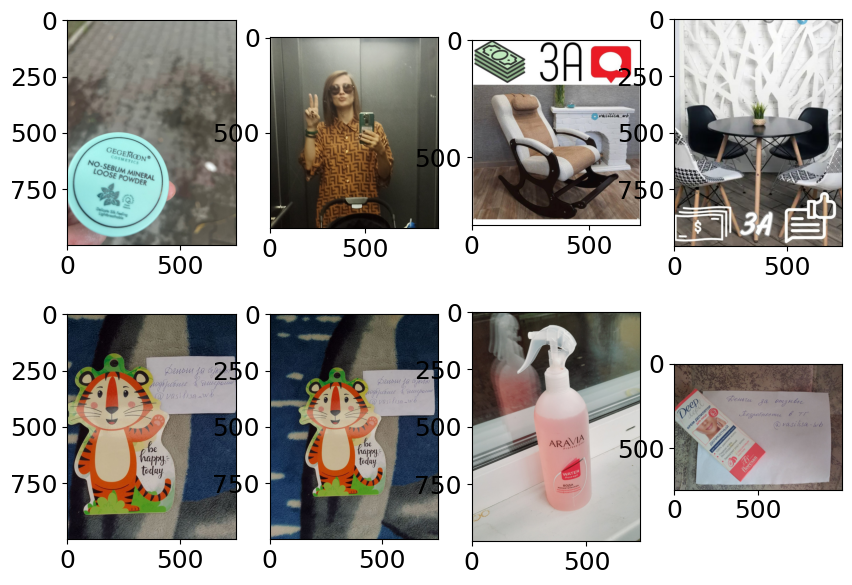

In [1144]:
def display(x, y, err, mas, accept):
    fig, axs = plt.subplots(x, y, figsize=(10, 7))
    j = 0
    for i in range(x*y):
        if accept:
            img = plt.imread(f"{path}\\train\\1\\{mas[err[i]]}")
        else:
            img = plt.imread(f"{path}\\train\\0\\{mas[err[i]]}")
        axs[j//y, j%y].imshow(img)
        j += 1

display(2, 4, err2, mas1, True)

Теперь будем искать недопустимые изображения среди допустимых. Принцип примерно тот же, отличие только в том, что дополнительно проверяется сходство слов с изображения и списка слов из недопустимых изображений до исправления в них ошибок, так как после исправления неоторые слова ошибочно становятся схожими со словами из списка слов из недопустимых изображений

In [1147]:
flag = False
err3 = []

def find_noice(err, flag, accept, text):
    global cnt
    for ind, text in tqdm(enumerate(text)):
        #print(text)
        new_text = []
        for elem in text:
            for el in elem.split():
                if el[0] == '@' and len(el) > 2:
                    new_text.append('@')
            elem = word_tokenize(elem)
            for el in elem:
                new_text.append(el.translate(str.maketrans('', '', '!"#$%&\'()@*+,-./:;<=>?[\\]^_`{|}~')))
        #print(new_text)
        for elem in new_text:
            correct = spell_checker.correction(elem) 
            if correct is None:
                correct = elem
            w = morph.parse(correct)[0].normal_form

            for stop in stop_words:
                if similar(stop, elem.lower()) >= 0.5 and similar(w, stop) >= 0.8 and len(elem) > 2 and len(w) > 2:
                    flag = True
                    #print(stop, elem)
                    break

            if not flag:
                for word in keys:
                    if similar(elem.lower(), word) >= 0.5 and similar(w, word) >= 0.8:
                        flag = True
                        #print(word, elem)
                        break

            if not flag:
                if elem[1:].isnumeric() and (elem[1] == '7' or elem[1] == '8') and len(elem) >= 8:
                        flag = True
                        #print(elem)

        if accept:
            if not flag:
                err.append(ind)
        else:
            if flag:
                err.append(ind)
        #print(flag)
        flag = False  
        #break

find_noice(err3, flag, False, text0)

0it [00:00, ?it/s]

2799it [34:11,  1.36it/s]


In [1149]:
print(f"Найдено недопустимых изображений = {len(err3)}")

Найдено недопустимых изображений = 120


Удалось отыскать недопустимые изображения, но вместе с ними есть и как "сомнительные", которые на мой взгляд сложно отнести к какому то определенному классу

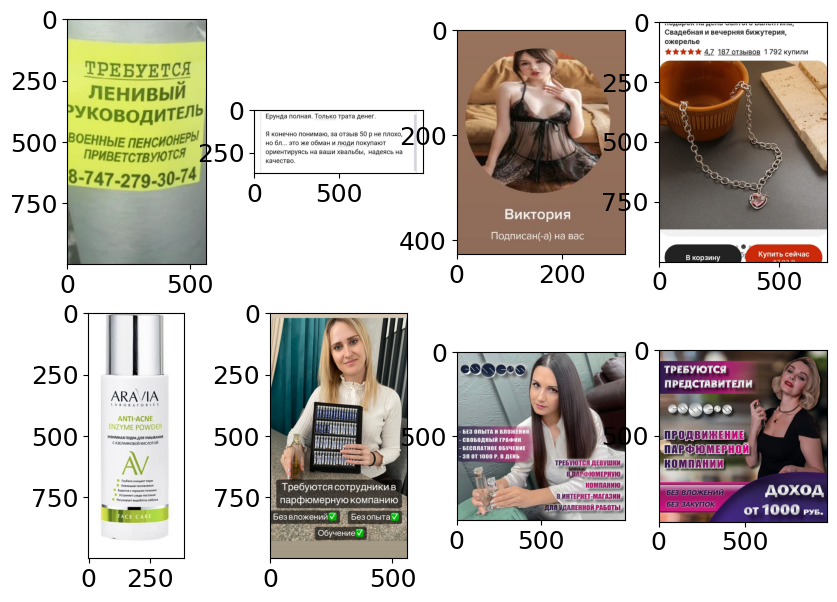

In [1159]:
display(2, 4, err3, mas0, False)

In [304]:
augmentetion = transforms.Compose([  
    transforms.RandomRotation(degrees=20),
    transforms.ColorJitter(brightness=0.5, contrast=0.5),
])

y0, y1 = [0 for i in range(len(new_mas0))], [1 for i in range(len(new_mas1))]
train0, test0, y_train, y_test = train_test_split(new_mas0, y0, test_size=0.33, random_state=42)
train1, test1, y_train, y_test = train_test_split(new_mas1, y1, test_size=0.33, random_state=42)

t = len(train0) // len(train1)
print(f"В тренировочной выборке кол-во допустимых изображений превышает кол-во недопустимых в {t} раз")

for i in range(t):
    for ind, img in enumerate(train1):
        img = Image.open(f"{path}\\1\\{img}")
        img.save(f"{path}\\new_train_1\\img_{ind}.jpg")

В тренировочной выборке кол-во допустимых изображений превышает кол-во недопустимых в 4 раз


'for i in range(t):\n    for ind, img in enumerate(train1):\n        img = Image.open(f"{path}\\1\\{img}")\n        img.save(f"{path}\\new_train_1\\img_{ind}.jpg")'